**Objective**: develop a recommendation system that can suggest menus that align with the user's past interactions and preferences.



# Set Up

In [61]:
!pip install -q tensorflow-recommenders

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import tensorflow_recommenders as tfrs

In [63]:
# load dataset (csv) into pandas dataframe
df = pd.read_csv("/content/legit_customer_sample.csv")

# Data Understanding

In [64]:
# show the sample of data in the dataframe
df.sample(3)

,trx_date,trx_date_detail,sales_id,concept,brand,outlet,district,city,menu_id,menu_type,menu_category,menu_category_detail,menu_name,quantity,user_id,user_created_at,user_tier_level,user_gender
22365,2023-01-01,2023-01-01 12:33:42 UTC,04d1be28-3835-4a16-8532-e361e1db924a,Resto,Pizza E Birra,"Pizza e Birra, Mall Emporium Pluit",Penjaringan,Jakarta Utara,7120dd21-b8e5-48bf-a8ed-2c9137da3cbc,Ala Carte,FOOD,SOUP & SALAD,Champion's Platter,1.0,538166fb-259e-41f6-ada8-4edebec25bc5,2021-04-20 12:35:33,Basic,M
1976,2023-01-08,2023-01-08 12:44:17 UTC,35ec32fe-5e01-4f5c-aaaa-4a1fbc1128d5,Resto,TPC,"TPC, Bintaro Exchange",Pondok Aren,Tangerang Selatan,b69907d0-a325-4b5a-bb48-2bb6abbae51a,Package Content,FOOD,FOOD MODIFIER,Setengah Matang,1.0,7f1c1614-7fad-42f4-a458-00bc79861c20,2021-04-02 13:40:47,Diamond,F
17896,2023-01-01,2023-01-01 13:39:30 UTC,d41ea08a-ed08-4ec6-a644-6240ce209242,Lifestyle,Social House,"Social House, Grand Indonesia",Menteng,Jakarta Pusat,23f4c743-458d-43bd-9a79-16236926ba6a,Ala Carte,FOOD,PASTA,Spaghetti Aglio Olio,1.0,6e553cff-aa48-4d2e-bbb6-ff5bb8136972,2022-12-31 08:51:17,Silver,M


In [65]:
# show the high-level overview of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26804 entries, 0 to 26803
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   trx_date              26804 non-null  object 
 1   trx_date_detail       26804 non-null  object 
 2   sales_id              26804 non-null  object 
 3   concept               26804 non-null  object 
 4   brand                 26804 non-null  object 
 5   outlet                26804 non-null  object 
 6   district              26804 non-null  object 
 7   city                  26804 non-null  object 
 8   menu_id               26804 non-null  object 
 9   menu_type             26804 non-null  object 
 10  menu_category         26804 non-null  object 
 11  menu_category_detail  26804 non-null  object 
 12  menu_name             26804 non-null  object 
 13  quantity              26804 non-null  float64
 14  user_id               26804 non-null  object 
 15  user_created_at    

In [66]:
# display the descriptive statistics of all numerical data
df.describe()

,quantity
count,26804.000000
mean,1.163520
std,0.580635
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,16.000000


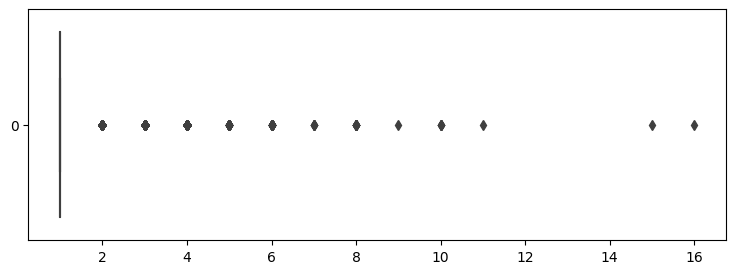

In [67]:
plt.figure(figsize=(9,3))
sns.boxplot(data=df['quantity'], orient='h')
plt.show()

In [68]:
# display the descriptive statistics of all categorical data (1)
# since there are lots of columns, the display will be seperated
df.describe(include='object').iloc[:, :8]

,trx_date,trx_date_detail,sales_id,concept,brand,outlet,district,city
count,26804,26804,26804,26804,26804,26804,26804,26804
unique,90,4332,4362,2,16,100,30,13
top,2023-01-01,2023-01-01 12:54:19 UTC,e89b8641-40fc-4783-ba43-4bf06db1635f,Resto,Djournal,"Osteria GIA, Plaza Indonesia",Menteng,Jakarta Selatan
freq,8520,129,129,19073,8208,1705,5008,9748


In [69]:
# display the descriptive statistics of all categorical data (2)
# since there are lots of columns, the display will be seperated
df.describe(include='object').iloc[:, 8:]

,menu_id,menu_type,menu_category,menu_category_detail,menu_name,user_id,user_created_at,user_tier_level,user_gender
count,26804,26804,26804,26804,26804,26804,26804,26804,26804
unique,2520,3,7,96,2030,1000,873,5,2
top,c482f57f-68ae-4f9b-b1a1-cd4c005279fc,Ala Carte,BEVERAGE,ESPRESSO BASED,Kopi Susu Batavia,49444c7e-8d84-4d57-ab95-108ef3dc386e,2022-04-19 19:20:59,Basic,F
freq,549,10666,14053,2874,549,729,1528,9125,15382


In [70]:
# Distribution of FnB Concept
fig = px.pie(df, names="concept", width=400, height=400)
fig.update_layout(margin=dict(t=20, b=0))

In [71]:
# Distribution of Brand
fig = px.histogram(df, y="brand", width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

In [72]:
# Distribution of City
fig = px.histogram(df, y="city", width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

In [73]:
# Distribution of Menu Type
fig = px.pie(df, names="menu_type", width=400, height=400)
fig.update_layout(margin=dict(t=20, b=0))

In [74]:
# Distribution of Menu Category
fig = px.histogram(df, y="menu_category", width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

In [75]:
# Distribution of Top 10 Menu Category Detail
freq_table = pd.crosstab(df['menu_category_detail'], '%_of_menu_category_detail')
freq_table = freq_table/len(df)
freq_table.sort_values('%_of_menu_category_detail', ascending=False)[:10]

col_0,%_of_menu_category_detail
menu_category_detail,
ESPRESSO BASED,0.107223
BEVERAGE MODIFIER,0.093083
KOPI BATAVIA BY DJOURNAL,0.069169
FOOD MODIFIER,0.067751
TEA,0.051858
PASTA,0.046299
FOOD ADDITIONAL,0.043725
TEA & COFFEE,0.041785
RICE & NOODLE,0.037942


In [76]:
# All menu category detail
df['menu_category_detail'].unique()

array(['APPETIZERS', 'BEVERAGE MODIFIER', 'WHISK(E)Y', 'SINGLE MALT',
       'CLASSIC COCKTAIL', 'SIGNATURE COCKTAIL', 'GIN',
       'SPECIAL COCKTAIL', 'KOPI BATAVIA BY DJOURNAL',
       'BEVERAGE ADDITIONAL', 'SOUP & SALAD', 'FOOD ADDITIONAL',
       'FOOD MODIFIER', 'MAINS', 'PASTA', 'BEER', 'SPECIAL MENU',
       'MOCKTAIL', 'DESSERT', 'ESPRESSO BASED', 'BLENDED',
       'WATER & SOFTIES', 'PIZZA', 'BEER PROMO', 'LITE BITES',
       'WATER & SOFTDRINKS', 'CLASSIC CRUST PIZZA',
       'NY STYLE GIANT PIZZA', 'FOOD PROMO', 'THIN CRUST PIZZA',
       'SPIRIT PROMO', 'FROM THE WOK', 'TEA & COFFEE', 'SIDES',
       'DESSERTS', 'TEA', 'APPETIZER', 'SUSHI ROLL', 'RICE & NOODLE',
       'JOSPER GRILL', 'CIGARETTE', 'ALL DAY BREAKFAST', 'LAND & SEA',
       'TEQUILA', 'RED WINE', 'WINE PROMO', 'LIQUOR', 'MOCKTAIL & JUICES',
       'APERITIF & DIGESTIF', 'MILK & CHOCOLATE', 'MOCKTAIL & JUICE',
       'SALAD', 'WHITE WINE', 'RAMEN', 'PASTRY & SANDWICH',
       'FRESHLY BREWED BY DJOURNAL', 'S

In [77]:
# Distribution of User Tier Level
fig = px.histogram(df, y="user_tier_level", width=800, height=400)
fig.update_layout(yaxis={'categoryorder':'total ascending'})

In [78]:
# Distribution of User Gender
fig = px.pie(df, names="user_gender", width=400, height=400, color_discrete_sequence=["red", "blue"])
fig.update_layout(margin=dict(t=20, b=0))

Based on the exploratory data analysis in the previous steps and with respect to the objective:
1. The recommendation system will be built using deep learning approach, utilizing TensorFlow Recommenders (TFRS) library.
2. The modeling steps with TFRS can be split into two tasks, that is the Retrieval modeling & Ranking modeling. In this notebook I will only explore the usage of Retrieval modeling algorithm.
3. The input of the system will be `user_id` and the output of the system will be `menu_name`.
4. Dependent features of `user_id` that will be the basis for recommendation is `menu_name` and aggregate `quantity`.
5. `menu_name` is a content filtering aspect, while `quantity` is a collaborative filtering aspect.
6. In content filtering, the system will recommend another menu that has similar name with a certain menu. With the assumption, a user would like to try a similar menu based on his/her previous transaction (interactions).
7. In collaborative filtering, the system will recommend another menu that has popularly purchased (sum of quantity) by other users. With the assumtions, a user would like to try a menu that is preferred among other users.
8. The recommendation system will be focused on recommending menu outside modifier, merchandise and others similar side category. This will be handled on data preparation steps.

# Data Preparation

Let's start cleaning the dataset

In [79]:
df_clean = df.copy()

In [80]:
# check the amount of missing values (based on rows)
droprow_strategy = df.dropna()
print("Number of row(s) WITH missing values: %d" % (df.shape[0]))
print("Number of row(s) WITHOUT missing values: %d" % (droprow_strategy.shape[0]))
print("Percentage of missing values in the dataset: %.2f" % ((df.shape[0] - droprow_strategy.shape[0])/df.shape[0]*100))

Number of row(s) WITH missing values: 26804
Number of row(s) WITHOUT missing values: 26804
Percentage of missing values in the dataset: 0.00


> This dataset doesn't contain any missing value

In [81]:
def outlier_percentage(dataframe):
  Q1 = dataframe.quantile(0.25)
  Q3 = dataframe.quantile(0.75)
  IQR = Q3 - Q1
  RLB = Q1 - 1.5 * IQR
  RUB = Q3 + 1.5 * IQR
  return ((dataframe < RLB) | (dataframe > RUB)).sum()/dataframe.count()*100

In [82]:
# counting the percentage of outlier in each column
outlier_percentage(df_clean.select_dtypes(include='number'))

quantity    10.91255
dtype: float64

> There's an outlier detected in this dataset by Tukey's method. I assume that if the outlier that present on a column is >=1%, it is indeed a real value recorded and is not an error from observation. Therefore, I don't have to handle those outliers.

> Based on the EDA steps, the maximum value of `quantity` data that is considered as an outlier are still logical (only 16)

In [83]:
# remove any duplicated row in this dataset
original_size = len(df_clean)
df_clean.drop_duplicates(inplace=True, ignore_index=True)
modified_size = len(df_clean)
print("Percentage of duplicated row(s) in the dataset: %.2f" % ((original_size - modified_size)/original_size*100))
print("Number of duplicated row(s) that has been dropped: %d" % (original_size - modified_size ))

Percentage of duplicated row(s) in the dataset: 5.28
Number of duplicated row(s) that has been dropped: 1416


In [84]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25388 entries, 0 to 25387
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   trx_date              25388 non-null  object 
 1   trx_date_detail       25388 non-null  object 
 2   sales_id              25388 non-null  object 
 3   concept               25388 non-null  object 
 4   brand                 25388 non-null  object 
 5   outlet                25388 non-null  object 
 6   district              25388 non-null  object 
 7   city                  25388 non-null  object 
 8   menu_id               25388 non-null  object 
 9   menu_type             25388 non-null  object 
 10  menu_category         25388 non-null  object 
 11  menu_category_detail  25388 non-null  object 
 12  menu_name             25388 non-null  object 
 13  quantity              25388 non-null  float64
 14  user_id               25388 non-null  object 
 15  user_created_at    

In [85]:
df_clean.sample()

,trx_date,trx_date_detail,sales_id,concept,brand,outlet,district,city,menu_id,menu_type,menu_category,menu_category_detail,menu_name,quantity,user_id,user_created_at,user_tier_level,user_gender
16532,2023-01-01,2023-01-01 14:37:40 UTC,b68f71b3-8471-472a-aa23-30aacf8691ea,Resto,Kitchenette,"Kitchenette, Pacific Place",Kebayoran Baru,Jakarta Selatan,c90d9cf7-ed3b-44d6-bb26-123d0787e9de,Package Head,BEVERAGE,TEA,Iced Tea,3.0,c255af32-e037-4681-86b6-b0f6e06df4f3,2021-04-26 04:57:34,Silver,F


> Up until here the dataset has been cleansed. The size of row has been reduced from 26.804 to 25.388

Let's engineered the original data/feature to meet our need

In [86]:
df_engineered = df_clean.copy()

In [87]:
# select only menu_name that is not fell into modifier, merchandise, and others similar category
unwanted_category_detail = ['BEVERAGE MODIFIER',
                            'BEVERAGE ADDITIONAL',
                            'FOOD ADDITIONAL',
                            'FOOD MODIFIER',
                            'SPECIAL MENU',
                            'BEER PROMO',
                            'FOOD PROMO',
                            'SPIRIT PROMO',
                            'BEVERAGE PROMO',
                            'MISCELLANEOUS',
                            'SPECIALS MENU',
                            'MERCHANDISE ',
                            'MERCHANDISE',
                            'OTHER']
df_engineered = df_engineered[~df_engineered['menu_category_detail'].isin(unwanted_category_detail)]
df_engineered.shape[0]

19258

In [88]:
# get the total number of orders a user has made on a given menu
# aggregate quantity based on user_id and menu_name
df_engineered = df_engineered.groupby(['user_id', 'menu_name'])['quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)

In [89]:
df_engineered.head(10)

,user_id,menu_name,quantity
2783,399873b2-415a-4000-98d5-5a637a6be8df,Long Black,116.0
2781,399873b2-415a-4000-98d5-5a637a6be8df,Large Hot Long Black,77.0
11743,daa94e08-b976-4413-956e-a86a4640b3c4,Reg Milk Kopi Ube,62.0
3641,49444c7e-8d84-4d57-ab95-108ef3dc386e,Reguler Milk Large,60.0
6566,7f1c1614-7fad-42f4-a458-00bc79861c20,Baso Goreng Dadakan 12K/Pcs,54.0
9357,b1337899-ea7c-44cd-9f20-e06651d4a186,Bintang Draught 330ml,53.0
11373,d390573f-f3e1-40f7-b6bb-f04405fa0e72,Large Milk Iced,52.0
11368,d390573f-f3e1-40f7-b6bb-f04405fa0e72,Iced Latte,49.0
11737,daa94e08-b976-4413-956e-a86a4640b3c4,Kopi Ube,48.0
13049,fa2b2ff7-f9f3-4705-9e02-a8e0760a74f5,Reg Milk Kopi Ube,36.0


# Modeling

## Retrieval algorithm/task

In [98]:
embedding_dimension = 32

### User's interactions (input query)

In [96]:
# translate the pandas dataframe into tensorflow dataset format
interactions_tensor = tf.data.Dataset.from_tensor_slices(dict(df_engineered))
interactions_tensor

<_TensorSliceDataset element_spec={'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'menu_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'quantity': TensorSpec(shape=(), dtype=tf.float64, name=None)}>

In [97]:
# map the tensorflow dataset rows into dictionary
# map the features to an identifier that will be used throught the embedding layers
interactions = interactions_tensor.map(lambda x: {'user_id' : x['user_id'],
                                                 'menu_name' : x['menu_name'],
                                                 'quantity' : x['quantity']})
interactions

<_MapDataset element_spec={'user_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'menu_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'quantity': TensorSpec(shape=(), dtype=tf.float64, name=None)}>

In [99]:
# create the tensorflow layers
user_id_lookup_layer = tf.keras.layers.StringLookup(mask_token=None)
user_id_lookup_layer.adapt(interactions_tensor.map(lambda x: x["user_id"]))
user_id_embedding_layer = tf.keras.layers.Embedding(input_dim=user_id_lookup_layer.vocabulary_size(), output_dim=embedding_dimension)

In [100]:
# compose the layers into a model
interactions_model = tf.keras.Sequential([
    user_id_lookup_layer,
    user_id_embedding_layer])

### Items (output candidate)

In [102]:
# translate the pandas dataframe into tensorflow dataset format
items_tensor = tf.data.Dataset.from_tensor_slices(dict(df_clean[['menu_name']]))
items_tensor

<_TensorSliceDataset element_spec={'menu_name': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [105]:
# create the DL layers
menu_name_vectorization_layer = tf.keras.layers.TextVectorization()
menu_name_vectorization_layer.adapt(items_tensor.map(lambda x: x['menu_name'])) # argument needs to be mapped like this or else error
menu_name_embedding_layer = tf.keras.layers.Embedding(input_dim=menu_name_vectorization_layer.vocabulary_size()+1,output_dim=embedding_dimension,mask_zero=True)

In [106]:
# compose the layers into a model
items_model = tf.keras.Sequential([
    menu_name_vectorization_layer,
    menu_name_embedding_layer,
    tf.keras.layers.GlobalAveragePooling1D()])

### Build the final model

In [107]:
# create a layer for computing the metrics
# it will compute "the top K candidates"
retrieval_task_layer = tfrs.tasks.Retrieval(
                        metrics=tfrs.metrics.FactorizedTopK(
                          candidates=items_tensor.map(lambda x: x['menu_name']).batch(128).map(items_model)))

In [109]:
# extend the tfrs class for building final model
class MenuRecommendationModel(tfrs.Model):
    def __init__(self, query_model, candidate_model, retrieval_task_layer):
        super().__init__()
        self.query_model = query_model
        self.candidate_model = candidate_model
        self.task = retrieval_task_layer

    def compute_loss(self, features, training=False):
        query_embeddings = self.query_model(features["user_id"])
        candidate_embeddings = self.candidate_model(features["menu_name"])
        return self.task(query_embeddings, candidate_embeddings)

In [110]:
# compile the model
model = MenuRecommendationModel(interactions_model, items_model, retrieval_task_layer)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))

### Model training & validation

In [115]:
# divide the train & validation dataset
temp = interactions_tensor.__len__().numpy()
shuffled_input = interactions_tensor.shuffle(buffer_size=temp, seed=42, reshuffle_each_iteration=False) # buffer size equal dataset size for perfect shuffling
train_size = 0.8 * temp
train_dataset = shuffled_input.take(train_size)
test_dataset = shuffled_input.skip(train_size)
print("train_dataset size: %d" % len(train_dataset))
print("test_dataset size: %d" % len(test_dataset))

train_dataset size: 10728
test_dataset size: 2682


In [116]:
# shuffle the train data for each epoch
trainset_cached = train_dataset.shuffle(10728).batch(8192).cache()
testset_cached = test_dataset.batch(4096).cache()

In [117]:
# train & validate the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_total_loss', mode="min", patience=3, verbose=1)

history = model.fit(
    trainset_cached,
    epochs=100,
    callbacks=[callback],
    validation_data=testset_cached
)

Epoch 1/100
2/2 [==============================] - 65s 31s/step - factorized_top_k/top_1_categorical_accuracy: 9.3214e-05 - factorized_top_k/top_5_categorical_accuracy: 9.3214e-05 - factorized_top_k/top_10_categorical_accuracy: 2.7964e-04 - factorized_top_k/top_50_categorical_accuracy: 0.0010 - factorized_top_k/top_100_categorical_accuracy: 0.0022 - loss: 37858.1016 - regularization_loss: 0.0000e+00 - total_loss: 37858.1016 - val_factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - val_factorized_top_k/top_5_categorical_accuracy: 7.4571e-04 - val_factorized_top_k/top_10_categorical_accuracy: 7.4571e-04 - val_factorized_top_k/top_50_categorical_accuracy: 0.0015 - val_factorized_top_k/top_100_categorical_accuracy: 0.0045 - val_loss: 21172.4297 - val_regularization_loss: 0.0000e+00 - val_total_loss: 21172.4297
Epoch 2/100
2/2 [==============================] - 64s 32s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 9.3214e

### Evaluate the model from its metrics

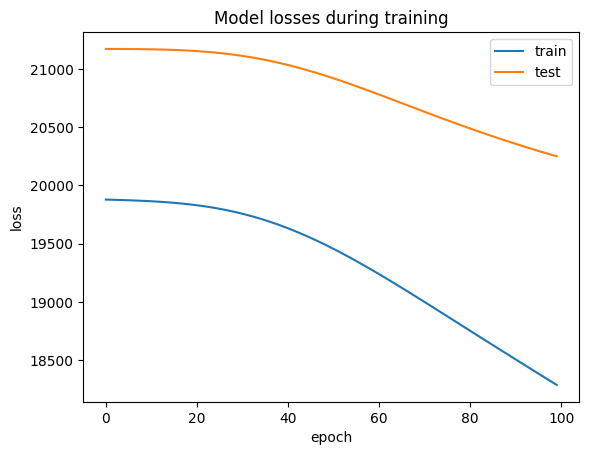

In [119]:
# Plot changes in model loss during training
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

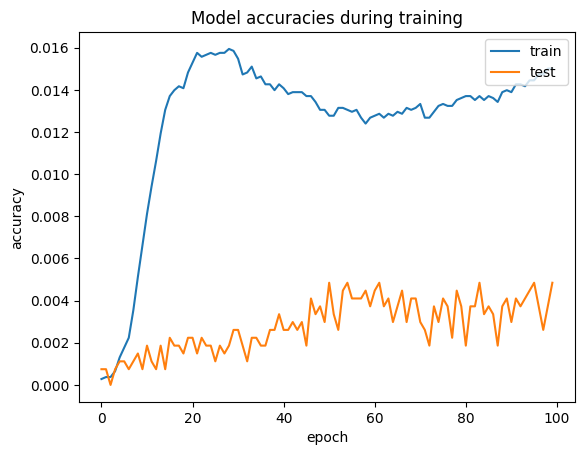

In [120]:
# Plot changes in model accuracy during training
plt.plot(history.history["factorized_top_k/top_10_categorical_accuracy"])
plt.plot(history.history["val_factorized_top_k/top_10_categorical_accuracy"])
plt.title("Model accuracies during training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "test"], loc="upper right")
plt.show()

### Test the model by making predictions

In [137]:
# check out the model output using BruteForce (top k recommendation)
brute_force = tfrs.layers.factorized_top_k.BruteForce(model.query_model, k=100)

items = items_tensor.map(lambda x: x['menu_name'])
# brute_force.index_from_dataset(
#     dict((items.batch(128), items.batch(128).map(model.candidate_model)))) # Dict[Text, tf.Tensor]

 # alternative
brute_force.index_from_dataset(items.batch(128).map(lambda menu_name: (menu_name, model.candidate_model(menu_name))))

In [139]:
df_clean.head(1)

,trx_date,trx_date_detail,sales_id,concept,brand,outlet,district,city,menu_id,menu_type,menu_category,menu_category_detail,menu_name,quantity,user_id,user_created_at,user_tier_level,user_gender
0,2023-01-04,2023-01-04 20:26:46 UTC,02d6de17-9ca4-480f-b13c-7336dccd64b9,Lifestyle,A/A,"Apothecary, Gunawarman",Kebayoran Baru,Jakarta Selatan,5204e17e-aefb-4235-8eb8-7177a5679352,Ala Carte,FOOD,APPETIZERS,French Fries,1.0,db0df3a5-2d00-4fed-93b1-99ea1eedccd8,2021-05-13 07:41:27,Gold,F


In [140]:
# choose a user
user_id = 'db0df3a5-2d00-4fed-93b1-99ea1eedccd8'

In [148]:
# print the recommendation
afinity_scores, menu_names = brute_force(tf.constant([user_id]))
print(f"3 Recommendations for user {user_id}: {menu_names[0, :3]}")

3 Recommendations for user db0df3a5-2d00-4fed-93b1-99ea1eedccd8: [b'Sazerac' b'Vodka Martini' b'Ginger']


# Evaluation & Conclusion

The model accuracy is still not good, hence this model need to be further trained in the future.